In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import  layers
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_bloch_multivector
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer.primitives import EstimatorV2

2024-11-02 22:33:17.513723: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 22:33:17.517484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 22:33:17.529199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 22:33:17.548927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 22:33:17.554978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 22:33:17.568705: I tensorflow/core/platform/cpu_feature_gu

In [2]:
data, ds_info = tfds.load(
    'cifar10',
    split='train',
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

I0000 00:00:1730597601.009758  156878 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-02 22:33:21.010352: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
df = tfds.as_dataframe(data.take(1000),ds_info)

2024-11-02 22:33:21.323976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-02 22:33:21.327354: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
cats_dogs = df.loc[(df.label == 3) | (df.label == 5)].reset_index()
cats_dogs = cats_dogs.drop(axis=0, columns='index')
cats_dogs.shape

(204, 2)

In [5]:
labels = cats_dogs.label.to_numpy().astype(np.uint8)
labels

array([5, 3, 3, 5, 3, 5, 3, 3, 3, 3, 5, 3, 5, 3, 3, 5, 3, 3, 5, 3, 5, 5,
       3, 3, 5, 3, 3, 5, 3, 5, 5, 3, 3, 3, 5, 3, 3, 5, 5, 3, 5, 3, 5, 3,
       5, 3, 5, 3, 3, 5, 5, 3, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 5, 3, 5,
       5, 3, 3, 3, 3, 5, 3, 5, 5, 3, 5, 3, 3, 5, 5, 5, 3, 3, 5, 3, 3, 3,
       5, 5, 5, 3, 5, 5, 5, 5, 3, 5, 5, 3, 5, 3, 5, 3, 5, 5, 5, 5, 5, 5,
       3, 3, 5, 5, 5, 5, 5, 3, 3, 3, 5, 5, 3, 5, 3, 3, 3, 5, 5, 3, 3, 3,
       3, 5, 5, 3, 5, 3, 5, 3, 5, 5, 3, 5, 5, 5, 3, 5, 3, 3, 3, 5, 5, 5,
       5, 5, 5, 5, 3, 3, 3, 5, 5, 5, 3, 5, 3, 3, 5, 3, 3, 5, 3, 3, 3, 5,
       3, 3, 3, 3, 3, 3, 5, 5, 3, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 3, 3, 3,
       3, 5, 5, 5, 5, 5], dtype=uint8)

In [6]:
original_images = np.stack(cats_dogs.image.to_numpy()/255.0)
original_images.shape

(204, 32, 32, 3)

In [7]:
images = np.zeros(shape=(204,10,10,1), dtype=np.float32)

In [8]:
for image_i in trange(images.shape[0]):
    new_image = original_images[image_i]

    new_image = tf.image.convert_image_dtype(new_image, dtype=tf.float32)
    new_image = tf.image.resize(new_image, (10,10))
    new_image = tf.image.rgb_to_grayscale(new_image)
    images[image_i] = new_image

100%|██████████| 204/204 [00:00<00:00, 695.73it/s]


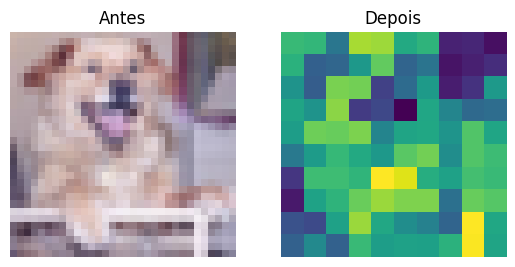

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)

ax1.imshow(cats_dogs.image[100])
ax1.set_title('Antes')
ax1.axis('off')


ax2.imshow(images[100])
ax2.set_title('Depois')
ax2.axis('off')

plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.10, random_state=37)

In [11]:
class QuantumConv2D(layers.Layer):
    def __init__(self):
        super(QuantumConv2D, self).__init__()
        self.w = self.add_weight(
            shape=(1,10),
            initializer=tf.constant_initializer(np.random.uniform(low=0, high=np.pi, size=(1,10))),
            trainable=True,
        )
        self._params = ParameterVector("theta",10)
        self._circuit = None
        self._obs = SparsePauliOp.from_list([("IIIZ",1), ("IIZI",1), ("IZII",1), ("ZIII",1)])
        self._estimator = EstimatorV2()
    
    def _build_circuit(self, data):
        self._circuit = QuantumCircuit(4)

        self._encode_data(data)

        self._circuit.barrier()

        self._circuit.rx(self._params[0], 0)
        self._circuit.rx(self._params[1], 1)
        self._circuit.rx(self._params[2], 2)
        self._circuit.rx(self._params[3], 3)

        self._circuit.crx(self._params[4], 1, 0)
        self._circuit.crz(self._params[5], 1, 0)

        self._circuit.crx(self._params[6], 2, 1)
        self._circuit.crx(self._params[7], 2, 1)

        self._circuit.crx(self._params[8], 3, 2)
        self._circuit.crz(self._params[9], 3, 2)


    @staticmethod
    def _get_angle(x):
        return 2*np.arcsin(x)

    def _encode_data(self, data):
        for i,pixel in enumerate(data):
            self._circuit.ry(self._get_angle(pixel), i)

    def _measure(self):
        output = np.zeros(shape=(4))
        weights = self.w.value.numpy()[0]
        results = self._estimator.run([(self._circuit, obs, weights) for obs in self._obs]).result()
        for i,result in enumerate(results):
            output[i] = result.data.evs
        return output

    def call(self,inputs):
        h,w,_ = inputs.shape
        output = np.zeros(shape=(4,h//2,w//2,1))

        for i in range(0,h,2):
            for j in range(0,w,2):
                data = [
                    inputs[i][j][0], 
                    0 if i+1 > h-1 else inputs[i+1][j][0], 
                    0 if j+1 > w-1 else inputs[i][j+1][0], 
                    0 if i+1 > h-1 or j+1 > w-1 else inputs[i+1][j+1][0]
                ]

                self._build_circuit(data)
                result = self._measure()
                
                output[1][i//2][j//2][0] = result[0]
                output[2][i//2][j//2][0] = result[1]
                output[2][i//2][j//2][0] = result[2]
                output[3][i//2][j//2][0] = result[3]

        return output

    def show_circuit(self):
        self._build_circuit([0,0,0,0])
        display(self._circuit.draw('mpl'))


In [12]:
class QuantumPool(layers.Layer):
    def __init__(self):
        super(QuantumPool, self).__init__()
        self.w = self.add_weight(
            shape=(1,6),
            initializer=tf.constant_initializer(np.random.uniform(low=0, high=np.pi, size=(1,6))),
            trainable=True,
        )
        self._params = ParameterVector("theta",6)
        self._circuit = None
        self._obs = SparsePauliOp('IIIZ')
        self._estimator = EstimatorV2()
    
    def _build_circuit(self, data):
        self._circuit = QuantumCircuit(4)

        self._encode_data(data)

        self._circuit.barrier()

        self._circuit.crz(self._params[0], 1,0)
        self._circuit.crx(self._params[1], 1,0)

        self._circuit.crz(self._params[2], 3,2)
        self._circuit.crx(self._params[3], 3,2)

        self._circuit.crz(self._params[4], 2,0)
        self._circuit.crx(self._params[5], 2,0)


    @staticmethod
    def _get_angle(x):
        return 2*np.arcsin(x)

    def _encode_data(self, data):
        for i,pixel in enumerate(data):
            self._circuit.ry(self._get_angle(pixel), i)

    def _measure(self):
        output = np.zeros(shape=(4))
        weights = self.w.value.numpy()[0]
        results = self._estimator.run([(self._circuit, self._obs, weights)]).result()
        return results[0].data.evs

    def call(self,inputs):
        n,h,w,_ = inputs.shape
        output = np.zeros(shape=(n,int(np.ceil(h/2)),int(np.ceil(w/2)),1))

        for c in range(n): 
            for i in range(0,h,2):
                for j in range(0,w,2):
                    data = [
                        inputs[c][i][j][0], 
                        0 if i+1 > h-1 else inputs[c][i+1][j][0], 
                        0 if j+1 > w-1 else inputs[c][i][j+1][0], 
                        0 if i+1 > h-1 or j+1 > w-1 else inputs[c][i+1][j+1][0]
                    ]
                    self._build_circuit(data)
                    result = self._measure()
                    output[c][i//2][j//2][0] = result

        return output

    def show_circuit(self):
        self._build_circuit([0,0,0,0])
        display(self._circuit.draw('mpl'))


In [13]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.conv = QuantumConv2D()
        self.pool = QuantumPool()
        self.fc = layers.Dense(3*3*4, activation="relu", input_shape=(36,))
        self.out = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv(inputs[0]) #in: 10x10 out: 5x5 with 4 channels(fiters)
        x = self.pool(x)
        x = np.expand_dims(x.flatten(), axis=0)
        x = self.fc(x)
        return self.out(x)


In [14]:
model = Model()

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
    run_eagerly=True
)

In [16]:
y_train[y_train == 3] = 0
y_train[y_train == 5] = 1

y_test[y_test == 3] = 0
y_test[y_test == 5] = 1

In [17]:
model.fit(x=X_train, y=y_train, epochs=20, batch_size=1)

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 114s 622ms/step - binary_accuracy: 0.4296 - loss: 0.7410
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 114s 623ms/step - binary_accuracy: 0.4948 - loss: 0.7251
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 114s 624ms/step - binary_accuracy: 0.5292 - loss: 0.7009
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 110s 604ms/step - binary_accuracy: 0.6200 - loss: 0.6797
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 116s 633ms/step - binary_accuracy: 0.5628 - loss: 0.6922
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 117s 640ms/step - binary_accuracy: 0.5836 - loss: 0.6892
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 116s 633ms/step - binary_accuracy: 0.5286 - loss: 0.6949
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 119s 650ms/step - binary_accuracy: 0.5708 - loss: 0.6797
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 113s 615ms/step - binary_accuracy: 0.5600 - loss: 0.6804
Epoch 10/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 141s 608ms/step - binary_accuracy: 0.5417 - loss: 0.6753
Epoch 11/20
183/183 ━━━━━━━━━

In [18]:
model.save("quantum.keras")

---

In [37]:
corrects = 0 
wrongs = 0

for i,x in enumerate(X_test):
    pred = np.round(model.predict(np.expand_dims(x,axis=0))[0][0])
    correct = y_test[i] == pred

    if(correct):
        print("Correct!")
        corrects += 1
    else:
        print("Wrong!")
        wrongs += 1
print(f"Corrects: {corrects}, Wrongs: {wrongs}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Correct!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Correct!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Correct!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Correct!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Correct!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Correct!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Wrong!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Wrong!
Corrects: 6, Wrongs: 1